In [1]:
import cv2
import torch
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
from approach.ResEmoteNet import ResEmoteNet

model = ResEmoteNet()
model.load_state_dict(torch.load("best_model.pth", map_location=device))

model.eval()

FourforAll(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (se): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
      (3): Sigmoid()
    )
  )
  (res_block1): ResidualBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [3]:
img_path = 'data/valid/test_0017_aligned_anger.jpg'

img = Image.open(img_path)

def process_image(image_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img).unsqueeze(0)  
    return img

In [4]:
from hook import Hook

final_layer = model.conv3
hook = Hook()
hook.register_hook(final_layer)

img_tensor = process_image(img_path)
logits = model(img_tensor)
probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

predicted_class_idx = predicted_class.item()
print(f'Predicted class: {predicted_class_idx}')

one_hot_output = torch.FloatTensor(1, probabilities.shape[1]).zero_()
one_hot_output[0][predicted_class_idx] = 1
logits.backward(one_hot_output, retain_graph=True)

gradients = hook.backward_out
feature_maps = hook.forward_out

hook.unregister_hook()

weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
cam = torch.sum(weights * feature_maps, dim=1, keepdim=True)
cam = cam.clamp(min=0).squeeze() 

cam -= cam.min()
cam /= cam.max()
cam = cam.cpu().detach().numpy()
cam = cv2.resize(cam, (64, 64))

Predicted class: 3


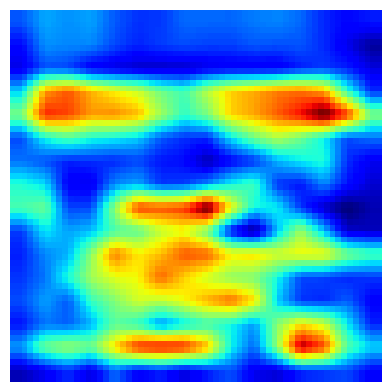

In [5]:
plt.matshow(cam, cmap='jet')
plt.axis('off')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


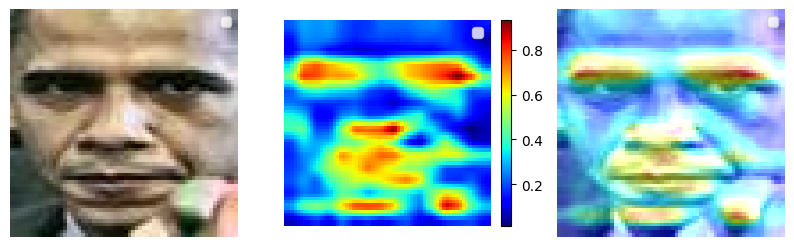

In [6]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
superimposed_img = heatmap*.5 + np.float32(img) / 255 # heatmap * 0.9
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.legend()

plt.subplot(1, 3, 2)
cax = plt.matshow(cam, cmap='jet', fignum=0)
plt.axis('off')
plt.colorbar(cax, ax=plt.gca(), fraction=0.045, pad=0.05)
plt.legend()

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.axis('off')
plt.legend()

plt.savefig('gcam_anger.png', dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()